In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(313949, 828)
(313949, 1)
validation
(37720, 828)
(37720, 1)
test
(42261, 828)
(42261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 47s - loss: 0.0343 - STD: 1.7008e-04 - MAE: 0.1777

 4/32 [==>...........................] - ETA: 0s - loss: 0.0234 - STD: 1.9528e-04 - MAE: 0.1144 

 5/32 [===>..........................] - ETA: 0s - loss: 0.0236 - STD: 1.9293e-04 - MAE: 0.1144

 6/32 [====>.........................] - ETA: 1s - loss: 0.0229 - STD: 1.9695e-04 - MAE: 0.1113

 7/32 [=====>........................] - ETA: 1s - loss: 0.0218 - STD: 2.0812e-04 - MAE: 0.1055

 8/32 [======>.......................] - ETA: 1s - loss: 0.0206 - STD: 2.2558e-04 - MAE: 0.0993

 9/32 [=======>......................] - ETA: 1s - loss: 0.0196 - STD: 2.4768e-04 - MAE: 0.0966

10/32 [========>.....................] - ETA: 1s - loss: 0.0190 - STD: 2.7122e-04 - MAE: 0.0967

11/32 [=========>....................] - ETA: 1s - loss: 0.0187 - STD: 2.9403e-04 - MAE: 0.0980

12/32 [==========>...................] - ETA: 0s - loss: 0.0185 - STD: 3.1592e-04 - MAE: 0.0991

13/32 [===========>..................] - ETA: 0s - loss: 0.0181 - STD: 3.3555e-04 - MAE: 0.0991

14/32 [============>.................] - ETA: 0s - loss: 0.0177 - STD: 3.5349e-04 - MAE: 0.0980

15/32 [=============>................] - ETA: 1s - loss: 0.0175 - STD: 3.6905e-04 - MAE: 0.0960

18/32 [===============>..............] - ETA: 1s - loss: 0.0166 - STD: 4.0214e-04 - MAE: 0.0897

20/32 [=================>............] - ETA: 0s - loss: 0.0162 - STD: 4.2096e-04 - MAE: 0.0865

21/32 [==================>...........] - ETA: 0s - loss: 0.0160 - STD: 4.3126e-04 - MAE: 0.0852

22/32 [===================>..........] - ETA: 0s - loss: 0.0159 - STD: 4.4290e-04 - MAE: 0.0840

23/32 [====================>.........] - ETA: 0s - loss: 0.0157 - STD: 4.5576e-04 - MAE: 0.0828

24/32 [=====================>........] - ETA: 0s - loss: 0.0155 - STD: 4.6995e-04 - MAE: 0.0821

25/32 [======================>.......] - ETA: 0s - loss: 0.0153 - STD: 4.8517e-04 - MAE: 0.0816

26/32 [=======================>......] - ETA: 0s - loss: 0.0152 - STD: 5.0153e-04 - MAE: 0.0815

27/32 [========================>.....] - ETA: 0s - loss: 0.0150 - STD: 5.1828e-04 - MAE: 0.0815

28/32 [=========================>....] - ETA: 0s - loss: 0.0149 - STD: 5.3511e-04 - MAE: 0.0815

29/32 [==========================>...] - ETA: 0s - loss: 0.0148 - STD: 5.5178e-04 - MAE: 0.0815

30/32 [===========================>..] - ETA: 0s - loss: 0.0147 - STD: 5.6842e-04 - MAE: 0.0813

31/32 [============================>.] - ETA: 0s - loss: 0.0146 - STD: 5.8444e-04 - MAE: 0.0809

32/32 [==============================] - ETA: 0s - loss: 0.0145 - STD: 5.9991e-04 - MAE: 0.0804

32/32 [==============================] - 4s 94ms/step - loss: 0.0145 - STD: 5.9991e-04 - MAE: 0.0804 - val_loss: 0.0144 - val_STD: 9.8644e-04 - val_MAE: 0.0698


Epoch 2/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0607

 2/32 [>.............................] - ETA: 1s - loss: 0.0110 - STD: 0.0011 - MAE: 0.0593

 3/32 [=>............................] - ETA: 1s - loss: 0.0110 - STD: 0.0011 - MAE: 0.0585

 4/32 [==>...........................] - ETA: 1s - loss: 0.0112 - STD: 0.0012 - MAE: 0.0583

 5/32 [===>..........................] - ETA: 1s - loss: 0.0112 - STD: 0.0012 - MAE: 0.0581

 6/32 [====>.........................] - ETA: 1s - loss: 0.0111 - STD: 0.0012 - MAE: 0.0580

 7/32 [=====>........................] - ETA: 1s - loss: 0.0111 - STD: 0.0012 - MAE: 0.0584

 8/32 [======>.......................] - ETA: 1s - loss: 0.0112 - STD: 0.0013 - MAE: 0.0590

 9/32 [=======>......................] - ETA: 1s - loss: 0.0112 - STD: 0.0013 - MAE: 0.0598

10/32 [========>.....................] - ETA: 1s - loss: 0.0112 - STD: 0.0014 - MAE: 0.0608

11/32 [=========>....................] - ETA: 1s - loss: 0.0112 - STD: 0.0014 - MAE: 0.0618

12/32 [==========>...................] - ETA: 1s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0627

13/32 [===========>..................] - ETA: 1s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0633

14/32 [============>.................] - ETA: 1s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0639

15/32 [=============>................] - ETA: 0s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0641

16/32 [==============>...............] - ETA: 0s - loss: 0.0112 - STD: 0.0017 - MAE: 0.0641

18/32 [===============>..............] - ETA: 0s - loss: 0.0111 - STD: 0.0018 - MAE: 0.0637

19/32 [================>.............] - ETA: 0s - loss: 0.0111 - STD: 0.0018 - MAE: 0.0635

20/32 [=================>............] - ETA: 0s - loss: 0.0111 - STD: 0.0019 - MAE: 0.0634

21/32 [==================>...........] - ETA: 0s - loss: 0.0111 - STD: 0.0019 - MAE: 0.0632

22/32 [===================>..........] - ETA: 0s - loss: 0.0111 - STD: 0.0020 - MAE: 0.0631

23/32 [====================>.........] - ETA: 0s - loss: 0.0111 - STD: 0.0021 - MAE: 0.0631

24/32 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 0.0022 - MAE: 0.0631

25/32 [======================>.......] - ETA: 0s - loss: 0.0111 - STD: 0.0022 - MAE: 0.0632

26/32 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.0023 - MAE: 0.0633

27/32 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 0.0024 - MAE: 0.0635

28/32 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.0025 - MAE: 0.0636

29/32 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 0.0027 - MAE: 0.0636

30/32 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 0.0028 - MAE: 0.0637

31/32 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 0.0029 - MAE: 0.0636

32/32 [==============================] - ETA: 0s - loss: 0.0110 - STD: 0.0030 - MAE: 0.0636

32/32 [==============================] - 2s 61ms/step - loss: 0.0110 - STD: 0.0030 - MAE: 0.0636 - val_loss: 0.0132 - val_STD: 0.0070 - val_MAE: 0.0693


Epoch 3/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0102 - STD: 0.0078 - MAE: 0.0602

 2/32 [>.............................] - ETA: 1s - loss: 0.0104 - STD: 0.0082 - MAE: 0.0610

 3/32 [=>............................] - ETA: 1s - loss: 0.0102 - STD: 0.0086 - MAE: 0.0609

 4/32 [==>...........................] - ETA: 1s - loss: 0.0101 - STD: 0.0090 - MAE: 0.0608

 5/32 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 0.0095 - MAE: 0.0608

 6/32 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 0.0100 - MAE: 0.0607

 7/32 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 0.0106 - MAE: 0.0608

 8/32 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 0.0111 - MAE: 0.0606

 9/32 [=======>......................] - ETA: 1s - loss: 0.0098 - STD: 0.0118 - MAE: 0.0605

10/32 [========>.....................] - ETA: 1s - loss: 0.0097 - STD: 0.0124 - MAE: 0.0602

11/32 [=========>....................] - ETA: 1s - loss: 0.0097 - STD: 0.0132 - MAE: 0.0600

12/32 [==========>...................] - ETA: 1s - loss: 0.0096 - STD: 0.0139 - MAE: 0.0597

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 0.0148 - MAE: 0.0593

14/32 [============>.................] - ETA: 1s - loss: 0.0093 - STD: 0.0157 - MAE: 0.0590

15/32 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 0.0168 - MAE: 0.0586

16/32 [==============>...............] - ETA: 0s - loss: 0.0091 - STD: 0.0179 - MAE: 0.0583

17/32 [==============>...............] - ETA: 0s - loss: 0.0090 - STD: 0.0191 - MAE: 0.0580

18/32 [===============>..............] - ETA: 0s - loss: 0.0089 - STD: 0.0204 - MAE: 0.0576

19/32 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0217 - MAE: 0.0573

20/32 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0231 - MAE: 0.0569

21/32 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 0.0246 - MAE: 0.0565

22/32 [===================>..........] - ETA: 0s - loss: 0.0084 - STD: 0.0261 - MAE: 0.0561

23/32 [====================>.........] - ETA: 0s - loss: 0.0083 - STD: 0.0276 - MAE: 0.0557

24/32 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.0292 - MAE: 0.0554

25/32 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0307 - MAE: 0.0550

26/32 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0322 - MAE: 0.0547

28/32 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0353 - MAE: 0.0540

29/32 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0368 - MAE: 0.0537

30/32 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0381 - MAE: 0.0533

31/32 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0394 - MAE: 0.0530

32/32 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0406 - MAE: 0.0526

32/32 [==============================] - 2s 62ms/step - loss: 0.0074 - STD: 0.0406 - MAE: 0.0526 - val_loss: 0.0059 - val_STD: 0.0748 - val_MAE: 0.0509


Epoch 4/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0414

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0413

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0407

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0405

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0404

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0402

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0401

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0828 - MAE: 0.0400

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0834 - MAE: 0.0399

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0836 - MAE: 0.0397

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0840 - MAE: 0.0395

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0845 - MAE: 0.0393

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0848 - MAE: 0.0391

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0851 - MAE: 0.0389

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0853 - MAE: 0.0387

16/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0856 - MAE: 0.0386

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0856 - MAE: 0.0384

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0857 - MAE: 0.0383

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0858 - MAE: 0.0381

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0861 - MAE: 0.0380

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0864 - MAE: 0.0379

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0868 - MAE: 0.0377

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0869 - MAE: 0.0376

24/32 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0871 - MAE: 0.0375

25/32 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0874 - MAE: 0.0374

26/32 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0877 - MAE: 0.0373

27/32 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0877 - MAE: 0.0372

28/32 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0878 - MAE: 0.0371

30/32 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0881 - MAE: 0.0369

31/32 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0882 - MAE: 0.0368

32/32 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0884 - MAE: 0.0367

32/32 [==============================] - 2s 62ms/step - loss: 0.0032 - STD: 0.0884 - MAE: 0.0367 - val_loss: 0.0036 - val_STD: 0.0900 - val_MAE: 0.0410


Epoch 5/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0345

 2/32 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.0931 - MAE: 0.0339

 3/32 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0927 - MAE: 0.0340

 4/32 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.0930 - MAE: 0.0339

 5/32 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0935 - MAE: 0.0339

 6/32 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0337

 7/32 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0934 - MAE: 0.0336

 8/32 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0336

 9/32 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0932 - MAE: 0.0336

10/32 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0336

11/32 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0935 - MAE: 0.0334

12/32 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0936 - MAE: 0.0334

13/32 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0334

14/32 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0941 - MAE: 0.0334

15/32 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0333

16/32 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0333

17/32 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0941 - MAE: 0.0333

18/32 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0941 - MAE: 0.0333

19/32 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0939 - MAE: 0.0332

20/32 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0941 - MAE: 0.0332

21/32 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0943 - MAE: 0.0331

23/32 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0941 - MAE: 0.0331

24/32 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0330

25/32 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0330

26/32 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0329

27/32 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0941 - MAE: 0.0329

28/32 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0328

29/32 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0945 - MAE: 0.0328

30/32 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0943 - MAE: 0.0328

31/32 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0327

32/32 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0942 - MAE: 0.0327

32/32 [==============================] - 2s 63ms/step - loss: 0.0024 - STD: 0.0942 - MAE: 0.0327 - val_loss: 0.0031 - val_STD: 0.1024 - val_MAE: 0.0386


Epoch 6/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0321

 2/32 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0316

 3/32 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0939 - MAE: 0.0316

 4/32 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0314

 5/32 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0315

 6/32 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0952 - MAE: 0.0315

 7/32 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0315

 8/32 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0956 - MAE: 0.0315

 9/32 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0314

10/32 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0313

11/32 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0313

12/32 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0313

13/32 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0312

14/32 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0312

15/32 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0312

16/32 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0312

17/32 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0958 - MAE: 0.0312

18/32 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0312

19/32 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0957 - MAE: 0.0312

20/32 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0311

21/32 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0311

23/32 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0311

24/32 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0956 - MAE: 0.0311

25/32 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0311

26/32 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

27/32 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

28/32 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

29/32 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0310

30/32 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0309

31/32 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0309

32/32 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0954 - MAE: 0.0309

32/32 [==============================] - 2s 62ms/step - loss: 0.0021 - STD: 0.0954 - MAE: 0.0309 - val_loss: 0.0028 - val_STD: 0.1059 - val_MAE: 0.0364


Epoch 7/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0306

 2/32 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.0956 - MAE: 0.0303

 4/32 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.0959 - MAE: 0.0301

 5/32 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0958 - MAE: 0.0302

 6/32 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0958 - MAE: 0.0301

 7/32 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0302

 8/32 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0960 - MAE: 0.0302

 9/32 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0962 - MAE: 0.0302

10/32 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0302

11/32 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0302

12/32 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0302

13/32 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0302

14/32 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0302

15/32 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0303

16/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0302

17/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0302

18/32 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0302

19/32 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0302

20/32 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0302

21/32 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0302

22/32 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0302

23/32 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0302

24/32 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0963 - MAE: 0.0303

25/32 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0303

26/32 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0303

27/32 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

28/32 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0303

29/32 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

30/32 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0303

31/32 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0303

32/32 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0303

32/32 [==============================] - 2s 61ms/step - loss: 0.0020 - STD: 0.0965 - MAE: 0.0303 - val_loss: 0.0030 - val_STD: 0.1099 - val_MAE: 0.0371


Epoch 8/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0299

 2/32 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.0950 - MAE: 0.0302

 3/32 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0947 - MAE: 0.0302

 4/32 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0305

 5/32 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

 6/32 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0303

 7/32 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0303

 8/32 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0303

 9/32 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

10/32 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0303

11/32 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0969 - MAE: 0.0303

12/32 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0303

13/32 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0962 - MAE: 0.0303

14/32 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0964 - MAE: 0.0303

15/32 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0304

16/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0303

17/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0304

18/32 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0967 - MAE: 0.0303

19/32 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0303

20/32 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0303

21/32 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0303

22/32 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0303

23/32 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0966 - MAE: 0.0302

24/32 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0302

25/32 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0965 - MAE: 0.0302

26/32 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0968 - MAE: 0.0302

27/32 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0302

28/32 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0302

29/32 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0302

30/32 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0302

32/32 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0964 - MAE: 0.0301

32/32 [==============================] - 2s 61ms/step - loss: 0.0019 - STD: 0.0964 - MAE: 0.0301 - val_loss: 0.0030 - val_STD: 0.1099 - val_MAE: 0.0371


Epoch 9/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0297

 2/32 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0294

 3/32 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0949 - MAE: 0.0294

 4/32 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0296

 6/32 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0969 - MAE: 0.0296

 7/32 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0967 - MAE: 0.0295

 8/32 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0295

 9/32 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0295

10/32 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0295

11/32 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0295

12/32 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0295

13/32 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0295

14/32 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0970 - MAE: 0.0295

15/32 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0295

16/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0295

17/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0295

18/32 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.0972 - MAE: 0.0295

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0295

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0294

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0294

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0294

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0294

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0294

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0294

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0294

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0293

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293

32/32 [==============================] - 2s 62ms/step - loss: 0.0018 - STD: 0.0970 - MAE: 0.0293 - val_loss: 0.0027 - val_STD: 0.1078 - val_MAE: 0.0356


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0970 - MAE: 0.0287

 2/32 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0291

 3/32 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0981 - MAE: 0.0291

 4/32 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0291

 5/32 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0291

 6/32 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0291

 7/32 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0291

 8/32 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0291

 9/32 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0291

10/32 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0291

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0969 - MAE: 0.0291

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0291

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0291

15/32 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.0969 - MAE: 0.0290

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0290

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0969 - MAE: 0.0290

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.0969 - MAE: 0.0290

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0291

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0291

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0291

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0291

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0291

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0291

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0291

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0290

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0290

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0290

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0290

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0290

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0290

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0290

32/32 [==============================] - 2s 62ms/step - loss: 0.0018 - STD: 0.0973 - MAE: 0.0290 - val_loss: 0.0027 - val_STD: 0.1083 - val_MAE: 0.0355


Epoch 11/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0966 - MAE: 0.0288

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.0959 - MAE: 0.0284

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.0967 - MAE: 0.0284

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0284

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.0969 - MAE: 0.0285

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0969 - MAE: 0.0285

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0286

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0286

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0968 - MAE: 0.0287

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0972 - MAE: 0.0287

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0287

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0972 - MAE: 0.0287

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0287

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0976 - MAE: 0.0287

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0287

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0288

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0288

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0977 - MAE: 0.0288

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0977 - MAE: 0.0288

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0288

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0287

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0287

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0288

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0287

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0287

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0287

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0287

32/32 [==============================] - 2s 61ms/step - loss: 0.0017 - STD: 0.0974 - MAE: 0.0287 - val_loss: 0.0027 - val_STD: 0.1084 - val_MAE: 0.0353


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0989 - MAE: 0.0284

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.0991 - MAE: 0.0284

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0284

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0285

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0285

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0975 - MAE: 0.0286

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0286

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0286

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0286

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0286

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0975 - MAE: 0.0285

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0283

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0283

15/32 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0284

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0284

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0284

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0284

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0284

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0284

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0976 - MAE: 0.0285

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0285

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0976 - MAE: 0.0286

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0285

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0285

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0976 - MAE: 0.0286

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0285

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0285

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0975 - MAE: 0.0285

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0975 - MAE: 0.0285

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0975 - MAE: 0.0285

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0976 - MAE: 0.0286

32/32 [==============================] - 2s 62ms/step - loss: 0.0017 - STD: 0.0976 - MAE: 0.0286 - val_loss: 0.0026 - val_STD: 0.1055 - val_MAE: 0.0357


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0295

 2/32 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.0980 - MAE: 0.0288

 3/32 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0289

 4/32 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.0970 - MAE: 0.0292

 5/32 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0290

 6/32 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0981 - MAE: 0.0290

 7/32 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0291

 8/32 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0978 - MAE: 0.0289

 9/32 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0981 - MAE: 0.0289

10/32 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0289

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0980 - MAE: 0.0288

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0982 - MAE: 0.0288

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0977 - MAE: 0.0288

14/32 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.0978 - MAE: 0.0288

15/32 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.0982 - MAE: 0.0289

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0290

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.0978 - MAE: 0.0290

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0290

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0289

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0289

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0289

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0289

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0289

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0288

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0974 - MAE: 0.0288

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0288

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0972 - MAE: 0.0287

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0287

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0973 - MAE: 0.0287

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0971 - MAE: 0.0287

32/32 [==============================] - 2s 60ms/step - loss: 0.0017 - STD: 0.0971 - MAE: 0.0287 - val_loss: 0.0029 - val_STD: 0.1137 - val_MAE: 0.0361


Epoch 14/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0287

 2/32 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0983 - MAE: 0.0282

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0280

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.0987 - MAE: 0.0282

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0282

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0281

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0281

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0281

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0280

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0279

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0280

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0279

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0279

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0278

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0278

16/32 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0279

17/32 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0278

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0277

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

32/32 [==============================] - 2s 71ms/step - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278 - val_loss: 0.0027 - val_STD: 0.1132 - val_MAE: 0.0352


Epoch 15/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0280

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0279

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0279

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0278

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0984 - MAE: 0.0279

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0994 - MAE: 0.0280

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0990 - MAE: 0.0280

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0988 - MAE: 0.0280

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0990 - MAE: 0.0280

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0280

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0985 - MAE: 0.0281

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0281

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0281

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0281

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0281

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0281

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0281

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0281

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0281

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0280

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0280

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0280

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0280

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0279

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0279

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0279

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

32/32 [==============================] - 2s 62ms/step - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278 - val_loss: 0.0026 - val_STD: 0.1111 - val_MAE: 0.0345


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0275

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.0965 - MAE: 0.0272

 3/32 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.0977 - MAE: 0.0274

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.0977 - MAE: 0.0273

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.0975 - MAE: 0.0273

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0273

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0274

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0274

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0274

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0275

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0276

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0277

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0276

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0276

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0275

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0274

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0274

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0275

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0274

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0274

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0274

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0274

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0274

32/32 [==============================] - 2s 67ms/step - loss: 0.0016 - STD: 0.0981 - MAE: 0.0274 - val_loss: 0.0027 - val_STD: 0.1136 - val_MAE: 0.0349


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

 2/32 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0984 - MAE: 0.0280

 3/32 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0285

 4/32 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0288

 5/32 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0995 - MAE: 0.0288

 6/32 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0986 - MAE: 0.0285

 7/32 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0281

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0983 - MAE: 0.0282

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0283

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0282

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0281

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0979 - MAE: 0.0281

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0279

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

16/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0279

17/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0278

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0278

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0977 - MAE: 0.0278

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0279

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0278

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0278

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0279

32/32 [==============================] - 3s 78ms/step - loss: 0.0017 - STD: 0.0981 - MAE: 0.0279 - val_loss: 0.0027 - val_STD: 0.1134 - val_MAE: 0.0351


Epoch 18/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0996 - MAE: 0.0275

 2/32 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0953 - MAE: 0.0281

 3/32 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0973 - MAE: 0.0279

 4/32 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0278

 5/32 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0966 - MAE: 0.0280

 6/32 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0280

 7/32 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0980 - MAE: 0.0279

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0977 - MAE: 0.0278

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0278

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0277

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0276

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0277

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0276

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0275

17/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

18/32 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0276

19/32 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0276

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0276

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0276

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0276

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0275

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0276

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0275

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0275

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0275

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0275

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0275

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0275

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0275

32/32 [==============================] - 3s 84ms/step - loss: 0.0016 - STD: 0.0981 - MAE: 0.0275 - val_loss: 0.0024 - val_STD: 0.1066 - val_MAE: 0.0341


Epoch 19/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0953 - MAE: 0.0283

 2/32 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0277

 3/32 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0977 - MAE: 0.0273

 4/32 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0967 - MAE: 0.0272

 5/32 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0976 - MAE: 0.0273

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0271

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0270

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0271

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0271

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0977 - MAE: 0.0271

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0976 - MAE: 0.0272

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0272

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0272

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0273

16/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0272

17/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0272

18/32 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0272

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0272

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0272

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0978 - MAE: 0.0272

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0272

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0272

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0272

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0272

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0272

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0271

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0271

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0271

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0271

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0980 - MAE: 0.0271

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0271

32/32 [==============================] - 3s 82ms/step - loss: 0.0016 - STD: 0.0982 - MAE: 0.0271 - val_loss: 0.0025 - val_STD: 0.1123 - val_MAE: 0.0338


Epoch 20/10000


 1/32 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259

 2/32 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0264

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0264

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0266

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1001 - MAE: 0.0266

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0996 - MAE: 0.0266

 7/32 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0265

 8/32 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0267

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0266

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0267

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0267

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0267

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0267

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0267

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0267

20/32 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0267

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0267

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0266

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0266

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266

32/32 [==============================] - 3s 89ms/step - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266 - val_loss: 0.0024 - val_STD: 0.1107 - val_MAE: 0.0333


Epoch 21/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0267

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0967 - MAE: 0.0268

 3/32 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0958 - MAE: 0.0269

 4/32 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0967 - MAE: 0.0272

 5/32 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0969 - MAE: 0.0272

 6/32 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0272

 7/32 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0271

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0270

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0269

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0269

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0267

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0267

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0268

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0267

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0980 - MAE: 0.0267

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0267

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0267

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0267

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0268

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0269

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0269

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0269

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0984 - MAE: 0.0269

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0270

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0271

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0271

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0271

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0271

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0271

32/32 [==============================] - 3s 80ms/step - loss: 0.0016 - STD: 0.0984 - MAE: 0.0271 - val_loss: 0.0028 - val_STD: 0.1155 - val_MAE: 0.0356


Epoch 22/10000


 1/32 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0279

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0269

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0267

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0271

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0271

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1000 - MAE: 0.0269

 7/32 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0272

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0991 - MAE: 0.0274

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0991 - MAE: 0.0273

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0991 - MAE: 0.0274

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0277

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0276

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0277

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0979 - MAE: 0.0278

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0278

16/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0987 - MAE: 0.0277

17/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0279

18/32 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0278

19/32 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0277

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0277

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0277

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0277

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0277

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0276

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0276

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0276

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0275

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0982 - MAE: 0.0275

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0275

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0274

32/32 [==============================] - 3s 84ms/step - loss: 0.0016 - STD: 0.0983 - MAE: 0.0274 - val_loss: 0.0024 - val_STD: 0.1122 - val_MAE: 0.0335


Epoch 23/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0262

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0270

 3/32 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0270

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0996 - MAE: 0.0268

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0266

 7/32 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0266

 8/32 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0266

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0265

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0264

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0265

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0265

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0265

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0264

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0265

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0264

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0264

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0264

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0264

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0264

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0264

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0263

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0263

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0263

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0263

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263

32/32 [==============================] - 3s 85ms/step - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263 - val_loss: 0.0024 - val_STD: 0.1129 - val_MAE: 0.0332


Epoch 24/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0263

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0981 - MAE: 0.0262

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0964 - MAE: 0.0260

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0967 - MAE: 0.0261

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0968 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.0971 - MAE: 0.0260

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.0974 - MAE: 0.0260

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0979 - MAE: 0.0261

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0981 - MAE: 0.0261

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0261

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0261

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0981 - MAE: 0.0261

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0980 - MAE: 0.0261

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0980 - MAE: 0.0261

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0261

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0261

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0261

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0261

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0261

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0261

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0261

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0261

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0261

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0261

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0261

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0261

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0261

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0260

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0260

32/32 [==============================] - 3s 83ms/step - loss: 0.0015 - STD: 0.0988 - MAE: 0.0260 - val_loss: 0.0024 - val_STD: 0.1129 - val_MAE: 0.0331


Epoch 25/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0255

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0256

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0257

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1006 - MAE: 0.0258

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0258

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0257

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0259

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0259

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0259

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0259

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0259

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0259

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0259

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0259

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0259

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259 - val_loss: 0.0024 - val_STD: 0.1148 - val_MAE: 0.0333


Epoch 26/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0256

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0259

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0259

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0265

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0268

 6/32 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0993 - MAE: 0.0271

 7/32 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0272

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0989 - MAE: 0.0272

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0270

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0269

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0268

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0268

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0267

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0268

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0268

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0267

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0267

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0266

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0267

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0266

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0266

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0266

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0266

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0266

32/32 [==============================] - 3s 84ms/step - loss: 0.0015 - STD: 0.0990 - MAE: 0.0266 - val_loss: 0.0023 - val_STD: 0.1120 - val_MAE: 0.0328


Epoch 27/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0983 - MAE: 0.0256

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0262

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0263

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0264

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0263

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0262

 7/32 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0262

 8/32 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0262

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0261

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0261

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0261

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0261

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0261

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0261

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0262

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0996 - MAE: 0.0263

18/32 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0263

19/32 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0262

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0262

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0262

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0262

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0263

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0262

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0262

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0262

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0263

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0263

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0263

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0262

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0262

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0263

32/32 [==============================] - 3s 86ms/step - loss: 0.0015 - STD: 0.0990 - MAE: 0.0263 - val_loss: 0.0023 - val_STD: 0.1101 - val_MAE: 0.0331


Epoch 28/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0269

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0265

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0261

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0260

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0999 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0260

 7/32 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0260

 8/32 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0260

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0259

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0259

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0260

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0261

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261

32/32 [==============================] - 3s 85ms/step - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261 - val_loss: 0.0024 - val_STD: 0.1143 - val_MAE: 0.0333


Epoch 29/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0259

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0980 - MAE: 0.0264

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0269

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0981 - MAE: 0.0269

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0987 - MAE: 0.0267

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0265

 7/32 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.0985 - MAE: 0.0264

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0264

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0263

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0988 - MAE: 0.0262

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0262

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0261

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0261

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0260

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0260

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259 - val_loss: 0.0033 - val_STD: 0.1215 - val_MAE: 0.0390


Epoch 30/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1071 - MAE: 0.0314

 2/32 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0972 - MAE: 0.0327

 3/32 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0312

 4/32 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0300

 5/32 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0977 - MAE: 0.0299

 6/32 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0986 - MAE: 0.0298

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0981 - MAE: 0.0292

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0289

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0983 - MAE: 0.0288

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0984 - MAE: 0.0285

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0283

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0990 - MAE: 0.0282

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0987 - MAE: 0.0280

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0992 - MAE: 0.0281

16/32 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0986 - MAE: 0.0281

17/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0280

18/32 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0991 - MAE: 0.0281

19/32 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0987 - MAE: 0.0281

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0280

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0988 - MAE: 0.0280

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0280

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0279

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0989 - MAE: 0.0279

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0987 - MAE: 0.0279

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0278

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0987 - MAE: 0.0278

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0277

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0277

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0276

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0985 - MAE: 0.0276

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0275

32/32 [==============================] - 3s 80ms/step - loss: 0.0016 - STD: 0.0986 - MAE: 0.0275 - val_loss: 0.0025 - val_STD: 0.1150 - val_MAE: 0.0340


Epoch 31/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1001 - MAE: 0.0264

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0984 - MAE: 0.0260

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0981 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0257

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0981 - MAE: 0.0256

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.0979 - MAE: 0.0256

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0979 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0976 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0977 - MAE: 0.0255

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0979 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0978 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0977 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0979 - MAE: 0.0255

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0982 - MAE: 0.0255

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0984 - MAE: 0.0255

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0984 - MAE: 0.0255

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0986 - MAE: 0.0255

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0986 - MAE: 0.0255

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0255

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0255

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0255

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0255

32/32 [==============================] - 3s 84ms/step - loss: 0.0014 - STD: 0.0992 - MAE: 0.0255 - val_loss: 0.0022 - val_STD: 0.1122 - val_MAE: 0.0323


Epoch 32/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0975 - MAE: 0.0259

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0257

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0256

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0257

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.0982 - MAE: 0.0258

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0984 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0257

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0257

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0256

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0257

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0257

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0257

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0259

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0259

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

32/32 [==============================] - 3s 81ms/step - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258 - val_loss: 0.0023 - val_STD: 0.1148 - val_MAE: 0.0326


Epoch 33/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1005 - MAE: 0.0255

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0257

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0258

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1009 - MAE: 0.0258

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0259

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1005 - MAE: 0.0259

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256 - val_loss: 0.0025 - val_STD: 0.1172 - val_MAE: 0.0339


Epoch 34/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0256

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0255

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0262

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0993 - MAE: 0.0262

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0260

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1003 - MAE: 0.0260

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0260

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0260

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0258

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0258

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

32/32 [==============================] - 3s 84ms/step - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257 - val_loss: 0.0023 - val_STD: 0.1157 - val_MAE: 0.0326


Epoch 35/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0251

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0250

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1011 - MAE: 0.0255

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0255

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0256

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0254

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0256

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0256

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0256

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0256

32/32 [==============================] - 3s 80ms/step - loss: 0.0014 - STD: 0.0995 - MAE: 0.0256 - val_loss: 0.0021 - val_STD: 0.1110 - val_MAE: 0.0318


Epoch 36/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0961 - MAE: 0.0265

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0989 - MAE: 0.0269

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.0982 - MAE: 0.0266

 4/32 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0264

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0992 - MAE: 0.0264

 6/32 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0264

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.0996 - MAE: 0.0263

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0262

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.0991 - MAE: 0.0260

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0260

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0258

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0258

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0257

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256 - val_loss: 0.0021 - val_STD: 0.1119 - val_MAE: 0.0316


Epoch 37/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0945 - MAE: 0.0248

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.0958 - MAE: 0.0250

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.0977 - MAE: 0.0252

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.0981 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0253

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0990 - MAE: 0.0252

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0252

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0252

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0252

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0252

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0253

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0252

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

32/32 [==============================] - 3s 80ms/step - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252 - val_loss: 0.0022 - val_STD: 0.1137 - val_MAE: 0.0319


Epoch 38/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1007 - MAE: 0.0248

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0252

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0254

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1011 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0259

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0260

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0257

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0257

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0257

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258 - val_loss: 0.0027 - val_STD: 0.1180 - val_MAE: 0.0348


Epoch 39/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0271

 2/32 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0975 - MAE: 0.0275

 3/32 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0275

 4/32 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1002 - MAE: 0.0269

 5/32 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.0996 - MAE: 0.0265

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0264

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0262

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1000 - MAE: 0.0261

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0260

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0260

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0259

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0257

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0257

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0994 - MAE: 0.0257 - val_loss: 0.0023 - val_STD: 0.1149 - val_MAE: 0.0322


Epoch 40/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0244

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0247

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0246

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0247

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0248

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0248

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0249

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0249

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

32/32 [==============================] - 3s 84ms/step - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249 - val_loss: 0.0023 - val_STD: 0.1166 - val_MAE: 0.0325


Epoch 41/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0252

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0252

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0257

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0258

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0257

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0254

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0254

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0253

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0253

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0253

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0253

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0254

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0254

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255 - val_loss: 0.0025 - val_STD: 0.1179 - val_MAE: 0.0336


Epoch 42/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0985 - MAE: 0.0258

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0254

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0258

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0257

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0257

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0256

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0256

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0257

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0256

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0256

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0256

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255

32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - STD: 0.0995 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.1136 - val_MAE: 0.0313


Epoch 43/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0961 - MAE: 0.0247

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.0968 - MAE: 0.0247

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0989 - MAE: 0.0247

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0991 - MAE: 0.0247

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0247

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0247

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0248

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0247

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0247

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0248

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0248

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0248

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0249

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0249

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0249

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

32/32 [==============================] - 3s 81ms/step - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248 - val_loss: 0.0022 - val_STD: 0.1145 - val_MAE: 0.0318


Epoch 44/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0973 - MAE: 0.0243

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.0987 - MAE: 0.0246

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0986 - MAE: 0.0244

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0243

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0246

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0248

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0250

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0250

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0251

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0250

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0250

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0251

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0251

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.1137 - val_MAE: 0.0314


Epoch 45/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0249

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1007 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0260

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0256

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0257

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0257

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0255

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0255

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0254

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0254

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0254

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0253

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0253

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0253

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0252

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251 - val_loss: 0.0022 - val_STD: 0.1164 - val_MAE: 0.0320


Epoch 46/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1026 - MAE: 0.0247

 2/32 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0247

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1006 - MAE: 0.0248

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0247

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.0989 - MAE: 0.0246

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0989 - MAE: 0.0246

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0991 - MAE: 0.0246

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0246

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0246

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0246

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0247

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0247

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0247

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0247

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0247

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0247

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0247

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0247

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0248

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

32/32 [==============================] - 3s 84ms/step - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250 - val_loss: 0.0026 - val_STD: 0.1176 - val_MAE: 0.0347


Epoch 47/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0264

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1013 - MAE: 0.0252

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0251

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1004 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1005 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1002 - MAE: 0.0251

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0253

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0253

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0252

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0252

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0252

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0252

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252

32/32 [==============================] - 3s 83ms/step - loss: 0.0014 - STD: 0.0997 - MAE: 0.0252 - val_loss: 0.0022 - val_STD: 0.1152 - val_MAE: 0.0317


Epoch 48/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1013 - MAE: 0.0249

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1013 - MAE: 0.0248

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0990 - MAE: 0.0248

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0248

 6/32 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0248

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0247

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0246

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0246

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0246

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0246

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0247

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0250

19/32 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0250

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0250

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0250

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0250

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0250

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0250

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251

32/32 [==============================] - 3s 82ms/step - loss: 0.0014 - STD: 0.0997 - MAE: 0.0251 - val_loss: 0.0023 - val_STD: 0.1156 - val_MAE: 0.0328


Epoch 49/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1008 - MAE: 0.0256

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0971 - MAE: 0.0251

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0983 - MAE: 0.0252

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0990 - MAE: 0.0250

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.0981 - MAE: 0.0249

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.0985 - MAE: 0.0250

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.0983 - MAE: 0.0249

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0986 - MAE: 0.0248

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0989 - MAE: 0.0247

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0247

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0246

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0246

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0991 - MAE: 0.0247

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0990 - MAE: 0.0247

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0247

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0247

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0248

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0249

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0249

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250

32/32 [==============================] - 3s 84ms/step - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250 - val_loss: 0.0021 - val_STD: 0.1128 - val_MAE: 0.0311


Epoch 50/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0971 - MAE: 0.0246

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.0986 - MAE: 0.0245

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0250

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0983 - MAE: 0.0252

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0254

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0254

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0252

 8/32 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1003 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0252

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0252

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0251

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0250

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0249

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0250

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

32/32 [==============================] - 3s 86ms/step - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249 - val_loss: 0.0020 - val_STD: 0.1118 - val_MAE: 0.0309


Epoch 51/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.0965 - MAE: 0.0249

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0259

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0254

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

 7/32 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0250

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0991 - MAE: 0.0250

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0250

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0250

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0250

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0250

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0249

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0991 - MAE: 0.0250

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0250

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0250

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0250

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0250

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0251

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0250

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0250

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0250

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0250

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249

32/32 [==============================] - 3s 81ms/step - loss: 0.0013 - STD: 0.0996 - MAE: 0.0249 - val_loss: 0.0021 - val_STD: 0.1149 - val_MAE: 0.0313


Epoch 52/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0245

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1009 - MAE: 0.0245

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0243

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0243

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0243

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0243

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0243

 8/32 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0243

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0243

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0243

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0243

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0243

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0245

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0244

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

32/32 [==============================] - 3s 85ms/step - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244 - val_loss: 0.0022 - val_STD: 0.1165 - val_MAE: 0.0316


Epoch 53/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0245

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1012 - MAE: 0.0245

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1014 - MAE: 0.0244

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1015 - MAE: 0.0245

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1005 - MAE: 0.0244

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0245

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0245

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0245

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0245

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1004 - MAE: 0.0246

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0246

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0247

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0247

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0247

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0247

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0248

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0248

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0248

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247

32/32 [==============================] - 3s 84ms/step - loss: 0.0013 - STD: 0.0999 - MAE: 0.0247 - val_loss: 0.0025 - val_STD: 0.1179 - val_MAE: 0.0334


Epoch 54/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0253

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1007 - MAE: 0.0249

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0250

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0250

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1018 - MAE: 0.0249

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1010 - MAE: 0.0246

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1006 - MAE: 0.0245

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1003 - MAE: 0.0245

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0245

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1005 - MAE: 0.0245

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1006 - MAE: 0.0245

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1003 - MAE: 0.0245

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1003 - MAE: 0.0245

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0245

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1004 - MAE: 0.0247

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0248

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0249

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0999 - MAE: 0.0251

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0250

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.0996 - MAE: 0.0251

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

32/32 [==============================] - 3s 84ms/step - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.1090 - val_MAE: 0.0322


Epoch 55/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0917 - MAE: 0.0274

 2/32 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0971 - MAE: 0.0271

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.0972 - MAE: 0.0260

 4/32 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.0963 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0978 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.0980 - MAE: 0.0256

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.0983 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0989 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0983 - MAE: 0.0256

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0256

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0988 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.0987 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0990 - MAE: 0.0254

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0253

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0253

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0253

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0252

18/32 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0252

19/32 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0252

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.0994 - MAE: 0.0251

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0251

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0250

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.0992 - MAE: 0.0250

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.0993 - MAE: 0.0250

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0250

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0249

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0249

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249

32/32 [==============================] - 3s 84ms/step - loss: 0.0013 - STD: 0.0993 - MAE: 0.0249 - val_loss: 0.0021 - val_STD: 0.1158 - val_MAE: 0.0313


Epoch 56/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0995 - MAE: 0.0241

 2/32 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.0984 - MAE: 0.0240

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0987 - MAE: 0.0241

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.0985 - MAE: 0.0241

 5/32 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.0984 - MAE: 0.0242

 6/32 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.0987 - MAE: 0.0241

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.0992 - MAE: 0.0241

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0242

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.0994 - MAE: 0.0241

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0242

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0241

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0241

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0242

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0242

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0242

17/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0243

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1004 - MAE: 0.0243

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0244

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0244

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1003 - MAE: 0.0244

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0244

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0244

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0245

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0245

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0245

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0245

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0245

32/32 [==============================] - 3s 83ms/step - loss: 0.0013 - STD: 0.0998 - MAE: 0.0245 - val_loss: 0.0025 - val_STD: 0.1180 - val_MAE: 0.0336


Epoch 57/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1023 - MAE: 0.0251

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1008 - MAE: 0.0246

 3/32 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.0993 - MAE: 0.0246

 4/32 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1003 - MAE: 0.0250

 5/32 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

 6/32 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0249

 7/32 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1004 - MAE: 0.0250

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.0995 - MAE: 0.0251

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0251

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0250

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0250

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0250

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0250

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0250

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0250

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0249

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.0998 - MAE: 0.0250

18/32 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0249

19/32 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1001 - MAE: 0.0249

21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0249

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0249

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0249

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0248

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1000 - MAE: 0.0248

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0248

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0248

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.0999 - MAE: 0.0248

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0248

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.0998 - MAE: 0.0248

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248

32/32 [==============================] - 3s 83ms/step - loss: 0.0013 - STD: 0.0996 - MAE: 0.0248 - val_loss: 0.0025 - val_STD: 0.1189 - val_MAE: 0.0339


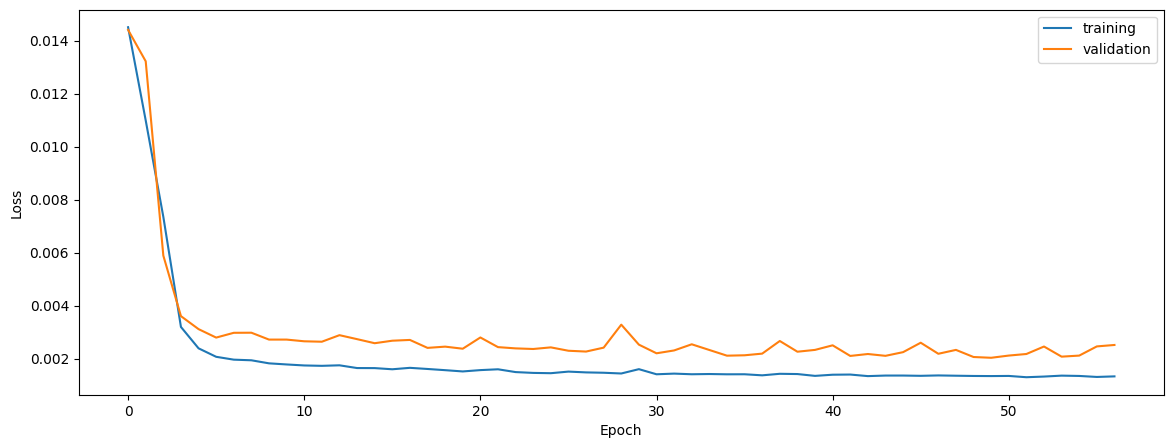

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9409069373264211
0.9317093698394321
0.9554349849605466


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9409069373264211
0.9317093698394321
0.9554349849605466


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9558774064575142
0.9485031496381706
0.9693644495253698


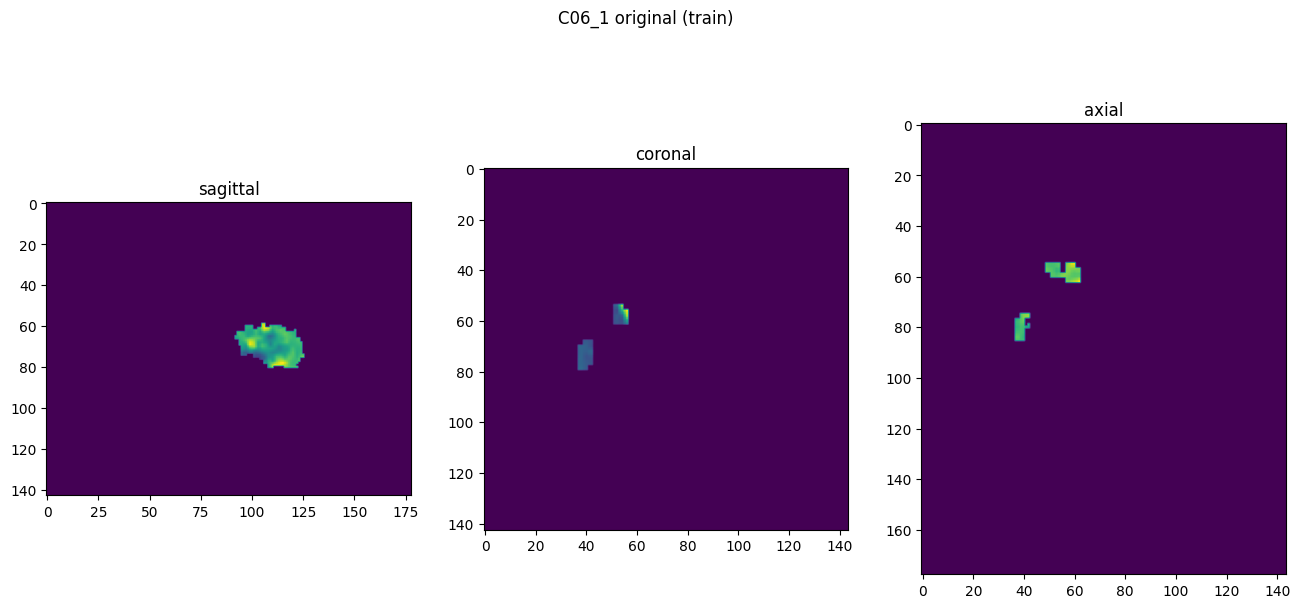

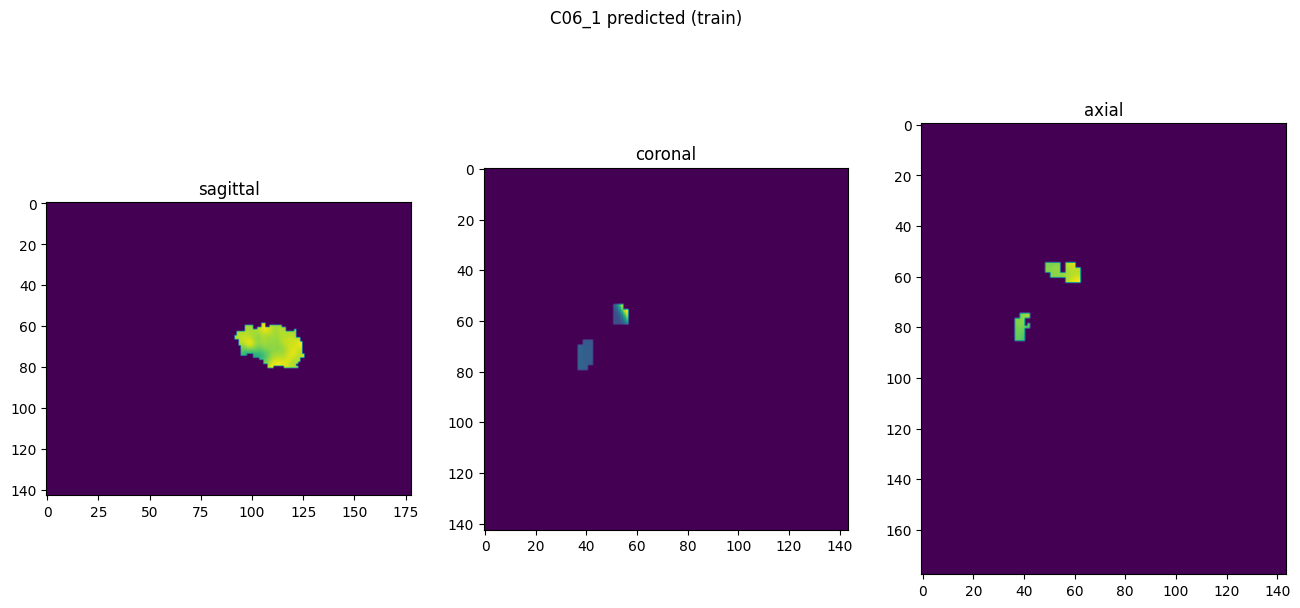

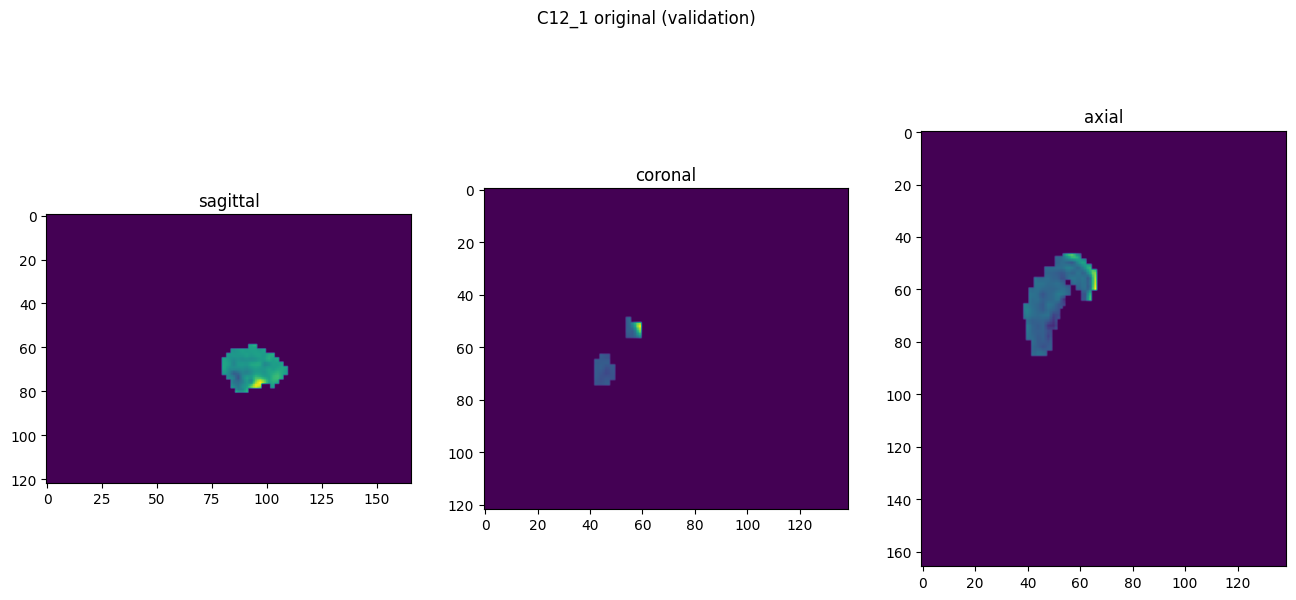

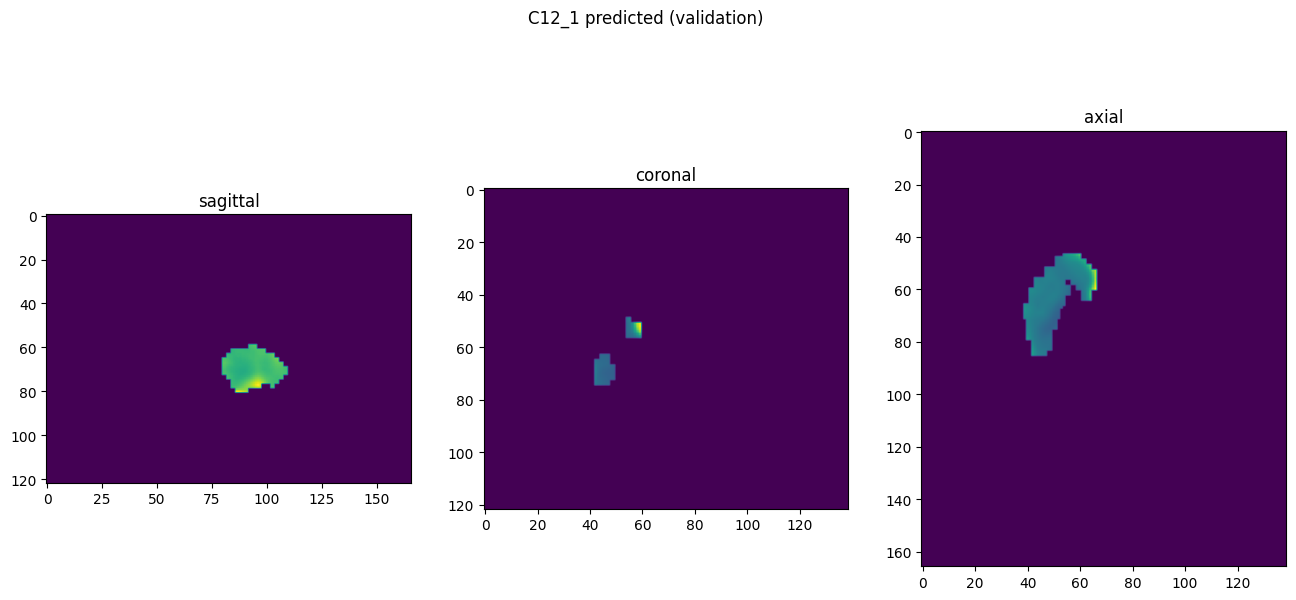

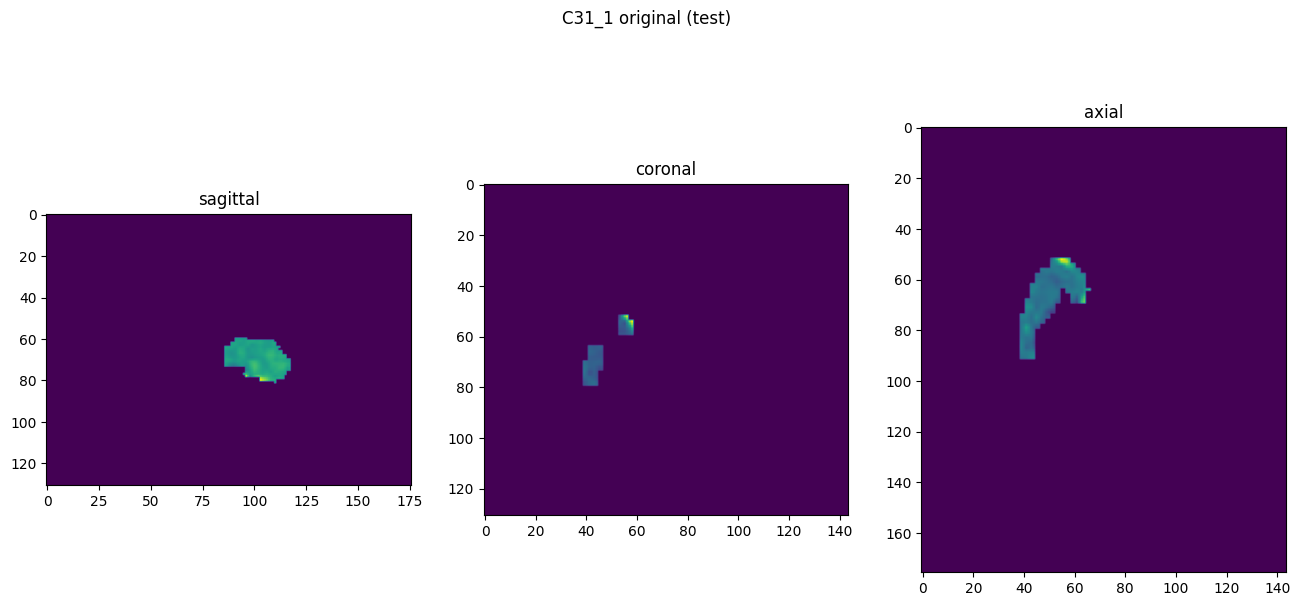

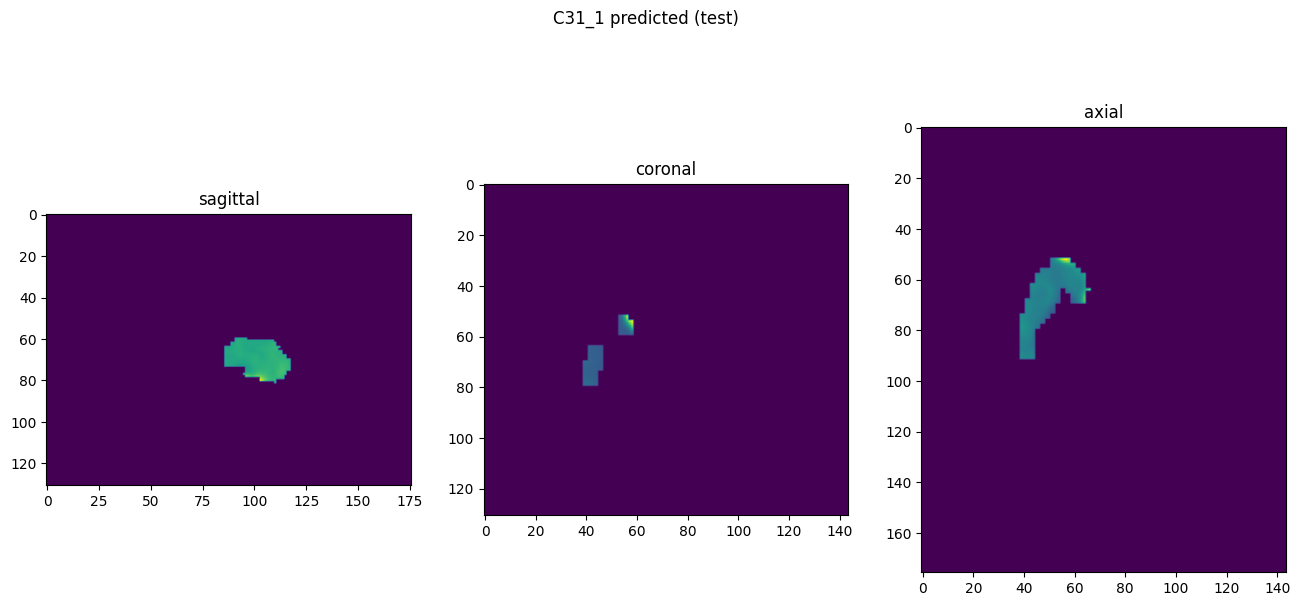

In [10]:
showResults(model, gen, threshold=None, background=False)